<a href="https://colab.research.google.com/github/yohanesnuwara/pyMRST/blob/main/notebooks/pyMRST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone pyMRST
!git clone https://github.com/yohanesnuwara/pyMRST

Cloning into 'pyMRST'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 201 (delta 38), reused 0 (delta 0), pack-reused 132
Receiving objects: 100% (201/201), 161.10 KiB | 1.25 MiB/s, done.
Resolving deltas: 100% (84/84), done.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Add directory where you install PyMRST
import sys
sys.path.append("/content/pyMRST") 

import pymrst
from pymrst_units import *

In [3]:
# Setup PyMRST (Takes about 3 minutes)
pymrst.setup()

## Functions

In [4]:
def write_input(nx, ny, nz, lx, ly, lz, poro, k, rock, fluid, well, 
                bc_front, bc_back, bc_left, bc_right, 
                numSteps=None, totTime=None, steps=None):
  """
  Convert inputs given in Python to write a MATLAB program that executes
  reservoir geometry, rock property, fluid, boundary condition creation 
  """
  input = "addpath /content/pyMRST \n"
  input += "addpaths\n\n"

  # # Timestep
  # input += "# Timestep\n"
  # input += "[numSteps, totTime] = deal({}, {}*day); \n".format(numSteps, totTime)
  # input += "steps = {}; \n\n".format(steps)

  # Reservoir geometry
  input += "# Reservoir geometry\n"
  input += "[nx,ny,nz] = deal({}, {}, {});\n".format(nx, ny, nz)
  input += "[lx,ly,lz] = deal({}, {}, {});\n".format(lx, ly, lz)
  input += "G = cartGrid([nx ny nz],[lx ly lz]);\n"
  input += "G = computeGeometry(G);\n\n"

  # Porosity 
  input += "# Porosity \n"
  if poro["type"]=="heterogeneous":
    if poro["field"]=="gaussian":
      input += "p = gaussianField(G.cartDims, [{} {}], [5 3 1], {});\n\n".format(poro["min"], poro["max"], poro["std"])

  # Permeability 
  input += "# Permeability \n"
  if k["type"]=="heterogeneous":
    if k["field"]=="kozeny":
      input += "K = p.^3.*(1e-5)^2./(0.81*72*(1-p).^2); \n\n"

  # Make rock
  input += "# Make rock\n"
  input +=  "rock = makeRock(G, K(:), p(:)); \n\n"

  # Rock PV calculation
  input += "# Rock PV \n"
  if fluid["type"]=="oil": # Slightly compressible simulation
    input += "cr = {}; \n".format(rock["c"])
    input += "p_r = {}; \n".format(rock["p_r"])
    input += "pv_r = poreVolume(G, rock); \n"
    input += "pv = @(p) pv_r .* exp( cr * (p - p_r) ); \n\n" 

  # Boundary conditions
  input += "# Boundary conditions \n"
  input += "bc = [];\n"

  bc_loc = ["'FRONT'", "'BACK'", "'LEFT'", "'RIGHT'"]
  bc_type = [bc_front["type"], bc_back["type"], bc_left["type"], bc_right["type"]]
  bc_val = [bc_front["value"], bc_back["value"], bc_left["value"], bc_right["value"]]

  for i in range(len(bc_type)):
    if i==0:
      # First boundary condition, bc=[]
      if bc_type[i]=="fluxside":
        input += "bc = fluxside([], G, {}, {});\n".format(bc_loc[i], bc_val[i])
      if bc_type[i]=="pside":
        input += "bc = pside([], G, {}, {});\n".format(bc_loc[i], bc_val[i])
    if i>0:
      if bc_type[i]=="fluxside":
        input += "bc = fluxside(bc, G, {}, {});\n".format(bc_loc[i], bc_val[i])
      if bc_type[i]=="pside":
        input += "bc = pside(bc, G, {}, {});\n".format(bc_loc[i], bc_val[i])      
  input += "\n"

  # Fluid
  # If a string, so single-phase (numphase=1)
  if type(fluid["type"])==str:
    input += "# Fluid is {}\n".format(fluid["type"])
    # Single phase
    if fluid["type"]=="water":
      input += "fluid     = initSingleFluid('mu', {}, 'rho', {});\n\n".format(fluid["mu"], fluid["rho"])
    if fluid["type"]=="oil":
      input += "mu = {}; \n".format(fluid["mu"])
      input += "c = {}; \n".format(fluid["c"])
      input += "rho_r = {}; \n".format(fluid["rho_r"])
      input += "rhoS = {}; \n".format(fluid["rhoS"])
      input += "rho = @(p) rho_r .* exp( c * (p - p_r) );\n\n"
      ## Timestep
      input += "# Timestep\n"
      input += "[numSteps, totTime] = deal({}, {}*day); \n".format(numSteps, totTime)
      input += "steps = {}; \n\n".format(steps)      

    if fluid["type"]=="gas":
      input += "mu = @(p) {}*(1+{}*(p-{})); \n".format(fluid["mu0"], fluid["c_mu"], fluid["p_r"])
      input += "@(p) {} .* exp( {} * (p - {}) );\n\n".format(fluid["rho_r"], fluid["c"], fluid["p_r"])
      ## Timestep
      input += "# Timestep\n"
      input += "[numSteps, totTime] = deal({}, {}*day); \n".format(numSteps, totTime)
      input += "steps = {}; \n\n".format(steps)  

  else:
    if len(fluid["type"])==2:
      # Two-phase
      print("no")

  # Well
  input += "# Well\n"
  if type(fluid["type"])==str:
    # Single-phase. Well doesn't have phase
    for i in range(len(well["type"])):
      well_loc = well["cell_loc"][i]
      well_type = well["type"][i]
      well_value = well["value"][i]
      well_radius = well["radius"][i]
      well_skin = well["skin"][i]
      well_direction = well["direction"][i]

      # Well locations convert to list to avoid breaking into new line
      input += "well_loc = {};".format(list(well_loc))  
      input += "\n"

      if well_type=="bhp":
        input += "pwf = {}; \n".format(well_value)      

      if i==0:
        # First well
        well_number = "[]"
      if i>0:
        # The next wells
        well_number = "W"

      if well_direction=="y":
        # Well is horizontal to y
        input += "W = addWell({}, G, rock, well_loc, 'Type', '{}', 'InnerProduct', 'ip_tpf', 'Val', {}, 'Radius', {}, 'Dir', 'y');\n\n".format(well_number, well_type, well_value, well_radius)
      elif well_direction=="x":
        # Well is horizontal to x
        input += "W = addWell({}, G, rock, well_loc, 'Type', '{}', 'InnerProduct', 'ip_tpf', 'Val', {}, 'Radius', {}, 'Dir', 'x');\n\n".format(well_number, well_type, well_value, well_radius)      
      else:
        # Well is vertical
        input += "W = addWell({}, G, rock, well_loc, 'Type', '{}', 'InnerProduct', 'ip_tpf', 'Val', {}, 'Radius', {});\n\n".format(well_number, well_type, well_value, well_radius)

  else:
    if len(fluid["type"])==2:
      # Two-phase. Well have phase
      a=2  

  # print(input)

  # write file instead of %%writefile
  # input_file = open("/content/INPUT.m", "w")
  input_file = open("/content/pyMRST/INPUT.m", "w")
  input_file.write(input)
  input_file.close()  

## Incompressible water

### Input

In [14]:
# Geometry
nx, ny, nz = 30, 20, 10
lx, ly, lz = 30, 20, 10

# Reservoir property                                         
poro = dict({"type": "heterogeneous", 
             "field": "gaussian", 
             "min": 0.2, "max": 0.4, "std": 2.5})

k = dict({"type": "heterogeneous", 
          "field": "kozeny"})

ntg = dict({"type": "heterogeneous", 
            "field": "lognorm", 
            "min": 0.4, "max": 0.6})

rock = dict({"c": 1e-6/barsa(), # Rock compressibility at ref pressure, 1/bar to 1/Pa
             "p_r": 200*barsa()}) # Reference pressure, bar to Pa             

# Fluid property: 1-phase water
fluid = dict({"type": "water", 
              "mu": 1*centi()*poise(), # cp to Pa.s 
              "rho": 1014})

# Boundary 
bc_front = dict({"type": "fluxside", "value": 50*stb()/day()}) # bbl/d to m3/s
bc_back = dict({"type": "fluxside", "value": 0})
bc_left = dict({"type": "fluxside", "value": 100/day()}) # m3/d to m3/s
bc_right = dict({"type": "pside", "value": 100*barsa()}) # bar to Pa

# Well
cell_loc1 = np.arange(10+60, nx*ny*nz, nx*ny)
cell_loc2 = np.arange(nx, nx*ny, ny)

# well = dict({"cell_loc": [cell_loc1, cell_loc2], 
#              "type": ["rate", "bhp"], 
#              "value": [(-10*stb()/day()), (110*barsa())], # bbl/d to m3/s, bar to Pa 
#              "radius": [.1, .1],
#              "skin": [0, 0], 
#              "direction": [None, "y"],
#              "phase": [[1,0], [0,1]]}) # Phase  

# well = dict({"cell_loc": [cell_loc1], 
#              "type": ["rate"], 
#              "value": [(-10*stb()/day())], # bbl/d to m3/s, bar to Pa 
#              "radius": [.1],
#              "skin": [0], 
#              "direction": [None]})  

well = dict({"cell_loc": [cell_loc1], 
             "type": ["bhp"], 
             "value": [100*1e5], # bbl/d to m3/s, bar to Pa 
             "radius": [.1],
             "skin": [0], 
             "direction": [None]})  

# Execute function
write_input(nx, ny, nz, lx, ly, lz, poro, k, rock, fluid, well, 
            bc_front, bc_back, bc_left, bc_right)

### Execute 

In [15]:
def water_1phase(nx, ny, nz, lx, ly, lz, poro, k, fluid, well, 
                 bc_front, bc_back, bc_left, bc_right):
  """
  MRST Incompressible Water Simulation
  """
  import oct2py as op
  # Execute writing MATLAB input program from given inputs
  # After executed, new .m file is created: INPUT.m
  write_input(nx, ny, nz, lx, ly, lz, poro, k, rock, fluid, well, 
              bc_front, bc_back, bc_left, bc_right)
  
  # Execute simulation program "water_1phase.m"
  # After executed, new .mat files (that contains PRESSURE, PORO, PERM result)
  # is created inside new directory "result_water_1phase"
  # !octave -W /content/pyMRST/water_1phase.m
  octave = op.Oct2Py()
  octave.run("/content/pyMRST/water_1phase.m")

In [16]:
# Execute simulator
# Simulator results are added in new directory "result_water_1phase"
water_1phase(nx, ny, nz, lx, ly, lz, poro, k, fluid, well, 
             bc_front, bc_back, bc_left, bc_right)

Computing one-sided transmissibilities...	Elapsed time is 0.00767589 seconds.
ans = 1


### Visualization

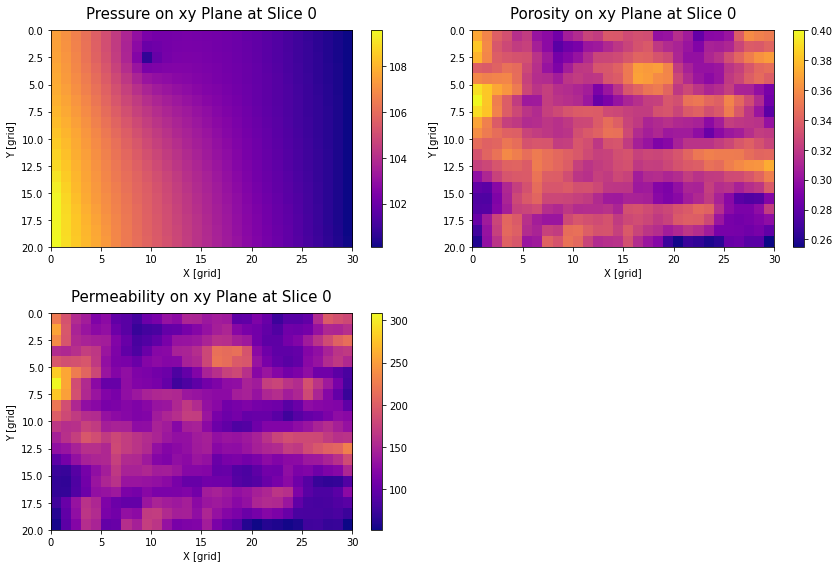

In [11]:
# Plot pressure, porosity, and permeability
plt.figure(figsize=(12,8))

# Inputs for plotting
directory = "/content/result_water_1phase"
filename = ["pressure.mat", "poro.mat", "perm.mat"]
plane, position = "xy", 0

# Plot
titles = ["Pressure", "Porosity", "Permeability"]

for i in range(3):
  plt.subplot(2,2,i+1)
  plt.title("{} on {} Plane at Slice {}".format(titles[i], plane, position),
          size=15, pad=12) 

  # Get cell data
  cube = pymrst.getCellData(directory, filename[i], dimension=(nx,ny,nz))

  # Convert units of pressure and permeability
  if i==0:
    # Convert metric (Pa) to field (psia)
    cube = cube/barsa()  
  if i==2:
    # Convert metric (Pa.s) to field (md)
    cube = cube/(milli()*darcy()) 

  # Plot cell data
  pymrst.plotCellData(cube, plane, position, cmap="plasma")

plt.tight_layout()
plt.show()

## Compressible oil simulation

### Input

In [5]:
# Geometry
nx, ny, nz = 30, 20, 10
lx, ly, lz = 200, 200, 50

# Reservoir property                                         
poro = dict({"type": "heterogeneous", 
             "field": "gaussian", 
             "min": 0.2, "max": 0.4, "std": 2.5})

k = dict({"type": "heterogeneous", 
          "field": "kozeny"})

ntg = dict({"type": "heterogeneous", 
            "field": "lognorm", 
            "min": 0.4, "max": 0.6})

# Rock property
rock = dict({"c": 1e-6*(1/1e+5), # Rock compressibility at ref pressure, 1/bar to 1/Pa
             "p_r": 200*1e+5}) # Reference pressure, bar to Pa

# Fluid property: 1-phase oil
fluid = dict({"type": "oil", 
              "mu": 5 * 0.001, # cp to Pa.s 
              "rho_r": 850, # Density at reference pressure
              "rhoS": 750, # Density on the surface
              "p_r": 200 * 1E+5, # Reference pressure, bar to Pa
              "c": 1e-3*(1/1E+5)}) # Fluid compressibility, 1/bar to 1/Pa 

# Boundary 
bc_front = dict({"type": "fluxside", "value": 50 * 1.84e-6}) # bbl/d to m3/s
bc_back = dict({"type": "fluxside", "value": 0})
bc_left = dict({"type": "fluxside", "value": 100 * 1.1574e-5}) # m3/d to m3/s
bc_right = dict({"type": "pside", "value": 100 * 1e+5}) # bar to Pa

# Well
# cell_loc1 = np.concatenate((np.arange(311,381+10,10), np.arange(411,481+10,10),
#                             np.arange(412,482+10,10), np.arange(312,382+10,10), 
#                             np.array([491,391])))

# well = dict({"cell_loc": [cell_loc1],
#              "type": ["bhp"],
#              "value": [100*1e5],
#              "radius": [.1],
#              "skin": [0],
#              "direction": ["y"]})

cell_loc1 = np.arange(10+60, nx*ny*nz, nx*ny)

well = dict({"cell_loc": [cell_loc1], 
             "type": ["bhp"], 
             "value": [100*1e5], # bar to Pa 
             "radius": [.1],
             "skin": [0], 
             "direction": [None]}) 

# Time step
numSteps, totTime = 52, 365
steps = [2, 5, 10, 20]

# Execute function
write_input(nx, ny, nz, lx, ly, lz, poro, k, rock, fluid, well, 
            bc_front, bc_back, bc_left, bc_right, numSteps, totTime, steps)

### Matlab script

### Execute

In [6]:
def oil_1phase(nx, ny, nz, lx, ly, lz, poro, k, fluid, well, 
               bc_front, bc_back, bc_left, bc_right, 
               numSteps, totTime, steps):
  """
  MRST Slightly Compressible Oil Simulation (Constant Viscosity over Pressure)
  """
  import oct2py as op
  # Execute writing MATLAB input program from given inputs
  # After executed, new .m file is created: INPUT.m
  write_input(nx, ny, nz, lx, ly, lz, poro, k, rock, fluid, well, 
              bc_front, bc_back, bc_left, bc_right, numSteps, totTime, steps)
  
  # Execute simulation program "oil_1phase.m"
  # After executed, new .mat files (that contains PRESSURE, PORO, PERM result)
  # is created inside new directory "result_oil_1phase"
  # !octave -W /content/pyMRST/oil_1phase.m
  octave = op.Oct2Py()
  octave.run("/content/pyMRST/oil_1phase.m")

In [7]:
# Execute simulator
# Simulator results are added in new directory "result_oil_1phase"
oil_1phase(nx, ny, nz, lx, ly, lz, poro, k, fluid, well, 
           bc_front, bc_back, bc_left, bc_right, numSteps, totTime, steps)


Time step 1: Time 0.00 -> 7.02 days
  Iteration   1:  Res = 1.0021e+07
  Iteration   2:  Res = 2.9707e-02
  Iteration   3:  Res = 2.1349e-05
  Iteration   4:  Res = 9.1910e-12

Time step 2: Time 7.02 -> 14.04 days
  Iteration   1:  Res = 1.2139e-01
  Iteration   2:  Res = 8.2228e-04
  Iteration   3:  Res = 4.7691e-08

Time step 3: Time 14.04 -> 21.06 days
  Iteration   1:  Res = 7.8036e-02
  Iteration   2:  Res = 3.4144e-04
  Iteration   3:  Res = 6.8400e-09

Time step 4: Time 21.06 -> 28.08 days
  Iteration   1:  Res = 6.6593e-02
  Iteration   2:  Res = 2.2535e-04
  Iteration   3:  Res = 2.4982e-09

Time step 5: Time 28.08 -> 35.10 days
  Iteration   1:  Res = 6.0507e-02
  Iteration   2:  Res = 1.8175e-04
  Iteration   3:  Res = 1.5339e-09

Time step 6: Time 35.10 -> 42.12 days
  Iteration   1:  Res = 5.5813e-02
  Iteration   2:  Res = 1.5467e-04
  Iteration   3:  Res = 1.1137e-09

Time step 7: Time 42.12 -> 49.13 days
  Iteration   1:  Res = 5.1671e-02
  Iteration   2:  Res = 1.3322

### Visualization

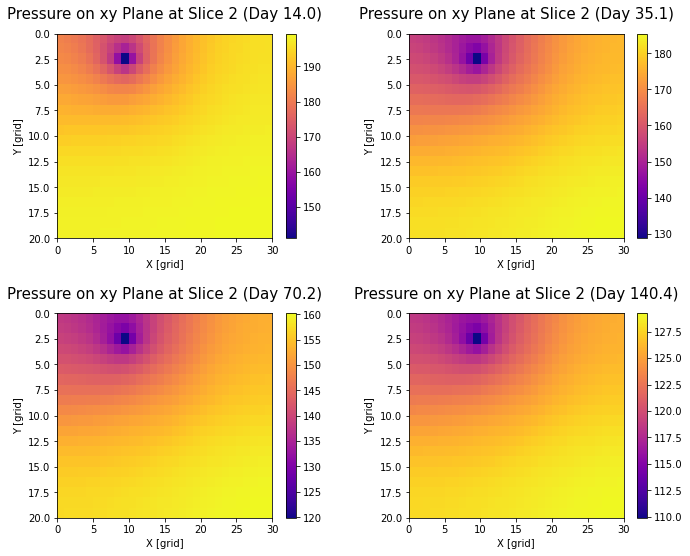

In [12]:
# Specify dimension
dimension = (nx,ny,nz)

# Input for plots
plane, position = "xy", 2

numSteps, totTime = 52, 365 # day
steps = [2, 5, 10, 20]

# Plot pressure for every timestep
plt.figure(figsize=(10,8))

for i in range(len(steps)):
  directory = "/content/result_oil_1phase/"
  filename = "pressure{}.mat".format(steps[i])

  # Get cell data 
  cube = pymrst.getCellData(directory, filename, dimension=(nx,ny,nz))

  # Convert to barsa
  cube = cube/barsa()

  # Plot for every timestep
  day = totTime / numSteps * steps[i]
  plt.subplot(2,2,i+1)
  pymrst.plotCellData(cube, plane, position, cmap="plasma")
  plt.title("Pressure on {} Plane at Slice {} (Day {:.1f})".format(plane, position, day),
            size=15, pad=15)  

plt.tight_layout(1.7)
plt.show()

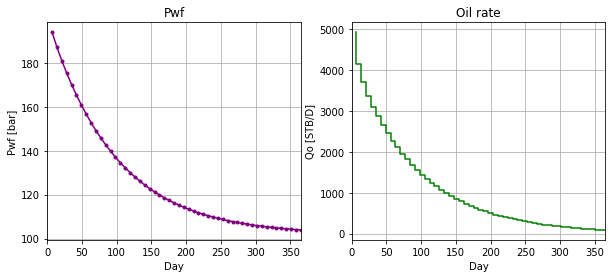

In [44]:
from pymrst_units import *

# Plot well solutions
directory = "/content/result_oil_1phase/"

time = pymrst.getWellSol(directory, "time.mat") / day() 
qo = pymrst.getWellSol(directory, "qo.mat") / (stb()/day())
Pwf = pymrst.getWellSol(directory, "Pwf.mat") / barsa() # convert to barsa

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(time, Pwf, ".-", color="purple")
plt.grid()
plt.title("Pwf")
plt.xlabel("Day"); plt.ylabel("Pwf [bar]")
plt.xlim(0,365)

plt.subplot(1,2,2)
plt.step(time, qo, color="green")
plt.grid()
plt.title("Oil rate")
plt.xlabel("Day"); plt.ylabel("Qo [STB/D]")
plt.xlim(0,365)

plt.show()